In [ ]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd


# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def calculate_curve_length(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线的总长度。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        float: 曲线的总长度。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个差值的欧氏距离，并求和
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    total_length = segment_lengths.sum()
    
    return total_length

def calculate_abscissas(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线每个点的累计弧长（abscissas）。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        numpy.ndarray: 一个形状为 (n,) 的数组，包含每个点对应的累计弧长。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个相邻点对之间的距离
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    
    # 计算累计弧长，起始点的弧长为 0
    abscissas = np.concatenate(([0], np.cumsum(segment_lengths)))
    
    return abscissas

curve_bs = np.load("../geom_aligned_curves_abj/geomstats_aligned_to_first_bravawithj.npy")[:-4]
curve_cs = np.load("../geom_aligned_curves_abj/geomstats_aligned_to_first_bravawithj.npy")[:-4]
# unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves_abj/total_files.npy")[:curve_bs.shape[0]]

print ("curve_bs.shape:", curve_bs.shape)
# print (unaligned_curvatures.shape)
print ("files length:", files.shape[0])

brava_num = len(curve_bs)
k_sampling_points = 120

original_centerlines = []
abscissas = []
for i in range(len(files)):
    # print ("files[i]:", files[i])
    original_centerline = Get_simple_vtk("../"+files[i])
    # print ("original_centerline.shape:", original_centerline.shape)
    print (calculate_curve_length(original_centerline), calculate_curve_length(curve_bs[i]))
    original_centerlines.append(original_centerline)
    abscissas.append(calculate_abscissas(original_centerline))



original_centerlines = np.array(original_centerlines)
abscissas = np.array(abscissas)

files_label = []
for i in range(len(files)):
    files_label.append("_".join([files[i].split('\\')[-1].split('.')[0].split('_')[0],files[i].split('\\')[-1].split('.')[0].split('_')[-1]]))

print (files_label)


curve_bs.shape: (79, 119, 3)
files length: 79
79.2532107896111 0.988287373259153
71.2856941716775 0.9807732379385738
81.99732061168635 0.9883072440705669
76.84593306337732 0.9868162645256428
84.42219706515498 0.98728184249317
82.51976985095165 0.9874980434120821
68.148084887353 0.9852561575309309
70.29056645709093 0.9867023434656611
62.64020846369101 0.9874736579534866
59.226106217694706 0.990212729475038
81.17170446694841 0.9872954676811688
72.55681136334347 0.9876538721878394
89.5732780821605 0.987967355093051
72.3216727210226 0.9862185350595626
93.31776822887464 0.98190259088653
90.63102213378802 0.981658770164441
68.49260917930133 0.9876193281470651
66.34326470721825 0.9865057656498606
78.0194813057584 0.9863008901413709
73.91862181493943 0.9810763130911232
80.31522199885775 0.979804324202744
80.39740696301176 0.9884739929810482
72.8872951189621 0.9846798402005845
72.45990096976132 0.9840407146592253
87.92834101687788 0.9860006746742415
84.83146452428466 0.9839835354707243
77.23885

In [ ]:
k_sampling_points = 120

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=True
)

curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_cs)

mean_estimate = mean.estimate_
tangent_base = mean.estimate_


d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


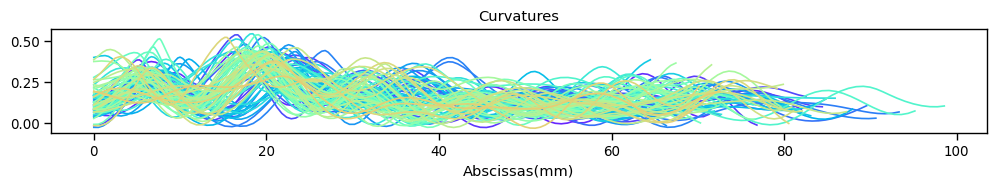

In [ ]:


def set_x_ticks_normalized(ax,x_array,num=5):
    ax.set_xlim(0, len(x_array) - 1)
    ax.set_xticks(np.linspace(0, len(x_array)-1, num=num))
    ax.set_xticklabels(['{:.2f}'.format(x) for x in np.linspace(0, 1, num=num)])
    ax.autoscale(enable=True, axis='x', tight=True)


curvatures = []
torsions = []
lengths = []
for i in range(len(curve_cs)):
    c,t = compute_curvature_and_torsion(original_centerlines[i])
    fft_c = remove_high_freq_components(c,0.05)
    fft_t = remove_high_freq_components(t,0.05)
    curvatures.append(fft_c)
    lengths.append(calculate_curve_length(original_centerlines[i]))
    torsions.append(fft_t)
curvatures = np.array(curvatures)
torsions = np.array(torsions)
lengths = np.array(lengths)

# 假设 curve_cs、abscissas、curvatures、torsions 已定义
# 使用 viridis 调色板
num_curves = len(curve_cs)
# colors = cm.hsv(np.linspace(0, 1, num_curves))  # 为每条曲线生成一个颜色
colors = cm.rainbow(np.linspace(0.05, 0.70, num_curves))
sns.set_context("paper", font_scale=1.1)
fig = plt.figure(figsize=(10, 2))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(212)

for i in range(num_curves):
    ax1.plot(abscissas[i], curvatures[i], color=colors[i], label='curve {}'.format(i))
    # ax2.plot(abscissas[i], torsions[i], color=colors[i], label='curve {}'.format(i))

ax1.set_title('Curvatures')
# ax2.set_title('Torsions')
ax1.set_xlabel('Abscissas(mm)')
# ax2.set_xlabel('Abscissas(mm)')


plt.tight_layout()
plt.show()

In [ ]:
print (files_label)

import vtk
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy

def read_vtk_maximum_inscribed_sphere(file_path):
    """
    Reads a .vtk file and extracts point data with the name 'MaximumInscribedSphere'.

    Parameters:
        file_path (str): The path to the .vtk file.

    Returns:
        np.ndarray: The array of 'MaximumInscribedSphere' data, or None if not found.
    """
    # Create a VTK reader
    reader = vtk.vtkGenericDataObjectReader()
    reader.SetFileName(file_path)
    reader.Update()

    # Get the data from the file
    data = reader.GetOutput()

    if data is None:
        raise ValueError(f"No data found in file: {file_path}")

    # Get point data
    point_data = data.GetPointData()
    if point_data is None:
        raise ValueError("No point data found in the VTK file.")

    # Extract the array with the name 'MaximumInscribedSphere'
    max_inscribed_sphere_data = point_data.GetArray("MaximumInscribedSphereRadius")
    if max_inscribed_sphere_data is None:
        raise ValueError("'MaximumInscribedSphereRadius' data not found in the point data.")

    # Convert the data to a NumPy array
    data_array = vtk_to_numpy(max_inscribed_sphere_data)

    return data_array

# Collect statistics from multiple files
def collect_statistics_from_files(file_paths):
    """
    Collects statistics for MaximumInscribedSphere from a list of VTK files.

    Parameters:
        file_paths (list): List of file paths to .vtk files.

    Returns:
        dict: Dictionary containing max, min, mean, and variance of the data.
    """
    all_data = []

    for file_path in file_paths:
        try:
            data = read_vtk_maximum_inscribed_sphere(file_path)
            all_data.extend(data)  # Combine data from all files
        except ValueError as e:
            print(f"Warning: {e} (file: {file_path})")

    if not all_data:
        raise ValueError("No valid data found in the provided files.")

    all_data = np.array(all_data)

    return {
        "Max": np.max(all_data),
        "Min": np.min(all_data),
        "Mean": np.mean(all_data),
        "Variance": np.var(all_data),
    }

# Main script
r_files = glob.glob("D:/!BraVa_src/src/ModeDecomposition/scaling/resamp_attr_ascii/vmtk64a/*.vtk")
stats = collect_statistics_from_files(r_files)

# Display statistics
print("Statistics for MaximumInscribedSphere:")
print(f"Max: {stats['Max']}")
print(f"Min: {stats['Min']}")
print(f"Mean: {stats['Mean']}")
print(f"Variance: {stats['Variance']}")

['BG0001_L', 'BG0001_R', 'BG0004_L', 'BG0004_R', 'BG0006_L', 'BG0006_R', 'BG0007_L', 'BG0007_R', 'BG0008_L', 'BG0008_R', 'BG0009_L', 'BG0009_R', 'BG0010_L', 'BG0010_R', 'BG0011_L', 'BG0011_R', 'BG0012_L', 'BG0012_R', 'BG0017_L', 'BG0017_R', 'BG0018_L', 'BG0018_R', 'BG0019_L', 'BG0019_R', 'BG0020_L', 'BG0020_R', 'BG0021_R', 'BG0022_L', 'BG0022_R', 'BH0005_L', 'BH0005_R', 'BH0006_L', 'BH0006_R', 'BH0009_L', 'BH0009_R', 'BH0010_L', 'BH0010_R', 'BH0011_L', 'BH0011_R', 'BH0013_L', 'BH0013_R', 'BH0014_L', 'BH0014_R', 'BH0016_L', 'BH0016_R', 'BH0017_L', 'BH0017_R', 'BH0018_L', 'BH0018_R', 'BH0019_L', 'BH0019_R', 'BH0020_L', 'BH0020_R', 'BH0021_L', 'BH0023_L', 'BH0024_L', 'BH0024_R', 'BH0025_R', 'BH0026_L', 'BH0026_R', 'BH0029_L', 'BH0029_R', 'BH0030_L', 'BH0030_R', 'BH0031_L', 'BH0031_R', 'BH0034_L', 'BH0034_R', 'BH0035_L', 'BH0035_R', 'BH0036_L', 'BH0036_R', 'BH0038_L', 'BH0038_R', 'BH0039_L', 'BH0039_R', 'BH0040_R', 'BI0001_L', 'BI0001_R']
Statistics for MaximumInscribedSphere:
Max: 3.69000

In [ ]:
for i in range(len(curvatures)):
    for j in range(len(curvatures[i])):
        if curvatures[i][j] < 0:
            print ("curvatures[i][j]:", curvatures[i][j])
            curvatures[i][j] = 0

curvatures[i][j]: -0.0012445377002382684
curvatures[i][j]: -0.004296142638915712
curvatures[i][j]: -5.4109004602276296e-05
curvatures[i][j]: -0.01562503203120249
curvatures[i][j]: -0.02551503172896557
curvatures[i][j]: -0.026656756301831237
curvatures[i][j]: -0.01908901382326017
curvatures[i][j]: -0.00353052901014218
curvatures[i][j]: -0.017472912007925633
curvatures[i][j]: -0.011132669585865751
curvatures[i][j]: -0.012207920651781615
curvatures[i][j]: -0.00761669666889578
curvatures[i][j]: -0.013229491489628915
curvatures[i][j]: -0.01306200616704598
curvatures[i][j]: -0.006209887422907319
curvatures[i][j]: -0.0030006016339619115
curvatures[i][j]: -0.006050153162581466
curvatures[i][j]: -0.002029097100322404
curvatures[i][j]: -0.018172819172771516
curvatures[i][j]: -0.02195128719387194
curvatures[i][j]: -0.012787687693467224
curvatures[i][j]: -0.008367863268145322
curvatures[i][j]: -0.019206576493811595
curvatures[i][j]: -0.0171893628658147
curvatures[i][j]: -0.0016800162917246803
curv

In [ ]:
# 存储统计结果
statistics = {
    "Length": {
        "Max": np.max(lengths),
        "Min": np.min(lengths),
        "Mean": np.mean(lengths),
        "Variance": np.var(lengths)
    },
    "Curvature": {
        "Max": np.max([np.max(curve) for curve in curvatures]),
        "Min": np.min([np.min(curve) for curve in curvatures]),
        "Mean": np.mean([np.mean(curve) for curve in curvatures]),
        "Variance": np.var([np.var(curve) for curve in curvatures])
    },
    # "Torsion": {
    #     "Max": np.max([np.max(curve) for curve in torsions]),
    #     "Min": np.min([np.min(curve) for curve in torsions]),
    #     "Mean": np.mean([np.mean(curve) for curve in torsions]),
    #     "Variance": np.var([np.var(curve) for curve in torsions])
    # }
}

# 转换为 DataFrame 格式
df_statistics = pd.DataFrame(statistics)

# 显示数据
df_statistics

Length  Curvature
Max       98.560688   0.542393
Min       59.226106   0.000000
Mean      75.079549   0.171788
Variance  61.434700   0.000010

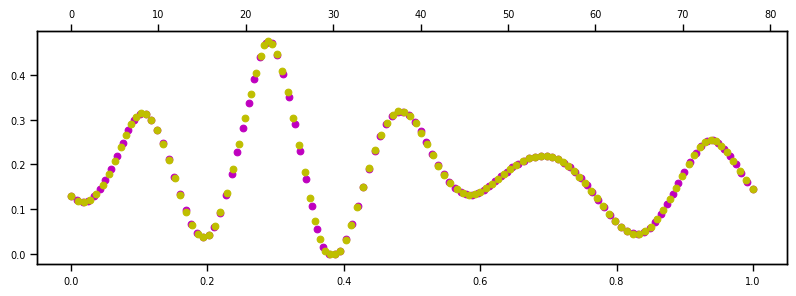

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

def parameterize_1d_curve(curve, abscissas):
    """
    Create a function to parameterize a 1D curve with non-uniform abscissas.
    
    :param curve: A 1D numpy array representing the curve's discrete y-values.
    :param abscissas: A 1D numpy array representing the x-values (abscissas) of the curve, should be the same length as `curve`.
    :return: A function that takes a vector of parameter values (t) and returns interpolated points on the curve.
    """
    # Normalize abscissas to the range [0, 1] for consistent parameterization
    t_values = (abscissas - abscissas.min()) / (abscissas.max() - abscissas.min())

    # Create an interpolation function for the curve
    interpolate_y = interp1d(t_values, curve, kind='cubic', fill_value="extrapolate")

    def curve_function(t_vector):
        # Clamp t_vector values to be within [0, 1]
        t_vector_clamped = np.clip(t_vector, 0, 1)
        
        # Interpolate y-values at the given t values
        y = interpolate_y(t_vector_clamped)
        return y

    return curve_function


reparam_curvatures = []
# 计算参数 t 在 [0, 1] 内的几个点上的插值值
t_vector = np.linspace(0, 1, curvatures.shape[1])
for i in range(len(files)):
    curve_func = parameterize_1d_curve(curvatures[i], abscissas[i])
    interpolated_points = curve_func(t_vector)
    reparam_curvatures.append(interpolated_points)

reparam_curvatures = np.array(reparam_curvatures)

i=18
sns.set_context("paper", font_scale=0.8)
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.scatter(t_vector, reparam_curvatures[i], color='m',label='Interpolated Curve')
ax2 = ax.twiny()
ax2.scatter(abscissas[i], curvatures[i], color='y', label='Original Curve Points')
# ax.legend()
# ax.set_title('Interpolated Curve vs. Original Points')
plt.tight_layout()
plt.show()

mean_function.shape: (120,)
aligned_curves.shape: (79, 120)
warping_functions.shape: (79, 120)


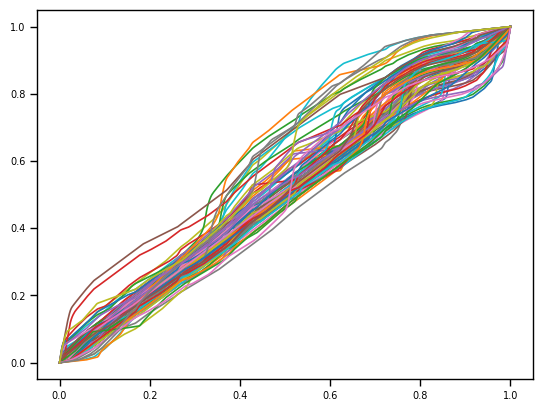

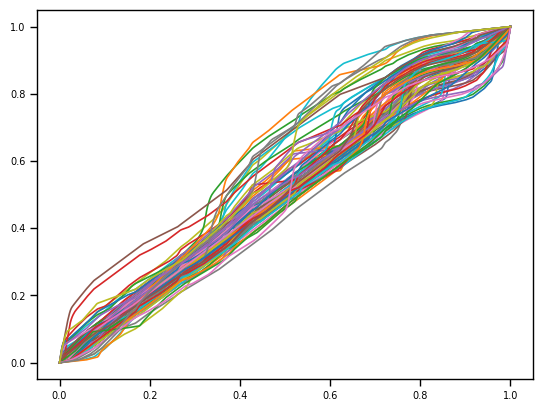

In [ ]:
# !pip install scikit-fda
from skfda.datasets import fetch_growth, make_multimodal_samples
from skfda.exploratory.stats import fisher_rao_karcher_mean
from skfda.preprocessing.registration import FisherRaoElasticRegistration
from skfda import FDataGrid

# curvatures = curve_bs[:,:,2]

# n, k = curvatures.shape
# print (n, k)
# x_grid = np.linspace(0, 1, k)
x_grid = t_vector.copy()

fd = FDataGrid(data_matrix=reparam_curvatures, grid_points=x_grid)

# 创建 FisherRaoElasticRegistration 对象
elastic_registration = FisherRaoElasticRegistration()

# 执行曲线对齐
fd_aligned = elastic_registration.fit_transform(fd)

# 计算对齐后的均值曲线 (Karcher Mean)
mean_function = fisher_rao_karcher_mean(fd_aligned).data_matrix[0,:,0]
print ("mean_function.shape:", mean_function.shape)


# 将对齐后的曲线数据提取为 numpy array
aligned_curvatures = fd_aligned.data_matrix[:,:,0]
print ("aligned_curves.shape:", aligned_curvatures.shape)

# 提取变形函数
warping_functions = elastic_registration.warping_.data_matrix[:,:,0]
print ("warping_functions.shape:", warping_functions.shape)
elastic_registration.warping_.plot()

Peak values: [0.27989762 0.39758205 0.23605529 0.17565155 0.21788394]
Peak indices: [  9  32  51  73 110]
Trough values: [0.10178144 0.12343176 0.07318757 0.05106733]
Trough indices: [19 44 63 86]


GLM  normalized index  curvature
0  L1          0.075000   0.279898
1  L3          0.266667   0.397582
2  L5          0.425000   0.236055
3  L7          0.608333   0.175652
4  L9          0.916667   0.217884
5  L2          0.158333   0.101781
6  L4          0.366667   0.123432
7  L6          0.525000   0.073188
8  L8          0.716667   0.051067

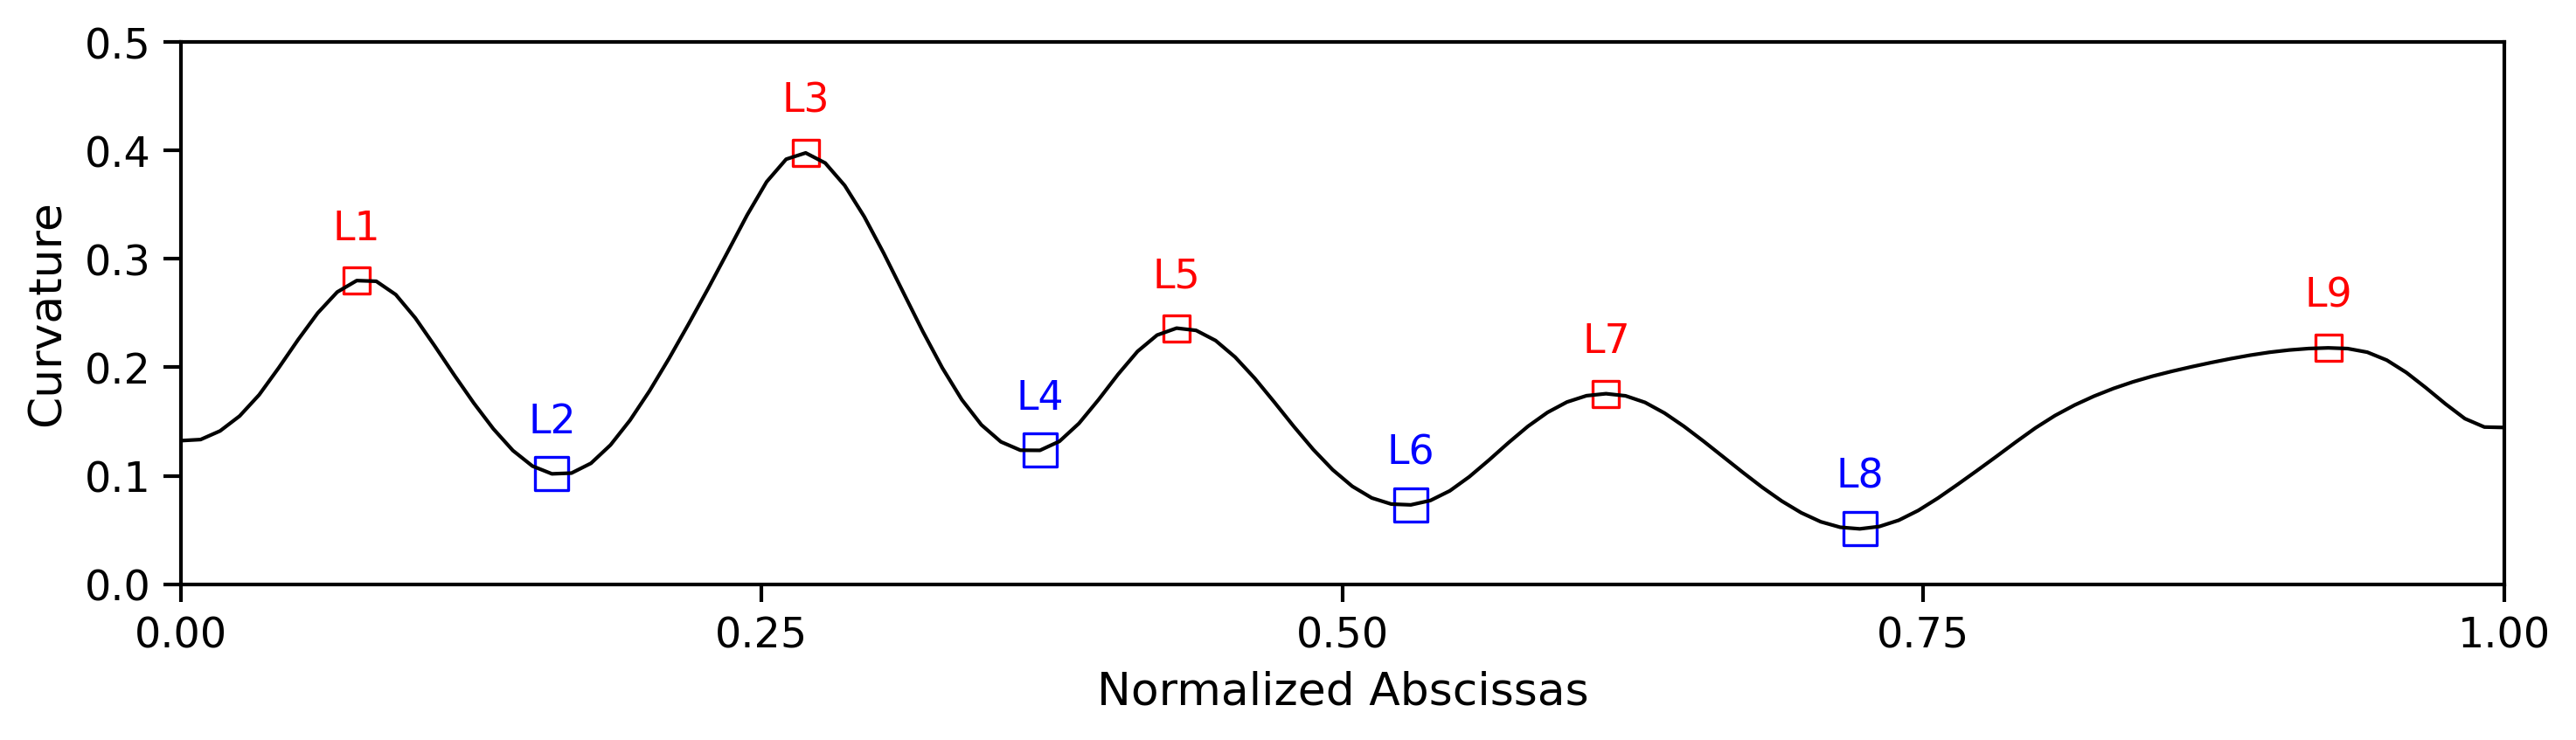

In [ ]:
import numpy as np
from scipy.signal import find_peaks
import seaborn as sns
# 假设 mean_function 已定义并为 1D numpy array
# mean_function = fisher_rao_karcher_mean(fd_aligned).data_matrix[0,:,0]

# 找到峰值的位置和对应的值
peak_indices, _ = find_peaks(mean_function)
peaks = mean_function[peak_indices]

# 找到谷值的位置和对应的值
trough_indices, _ = find_peaks(-mean_function)
troughs = mean_function[trough_indices]

# 输出峰值和谷值
print("Peak values:", peaks)
print("Peak indices:", peak_indices)
print("Trough values:", troughs)
print("Trough indices:", trough_indices)

sns.set_context("paper", font_scale=1.3)
import pandas as pd

# Initialize a list to store data for the DataFrame
data = []

# Create the figure and axis
fig = plt.figure(figsize=(10, 3), dpi=300)
ax = fig.add_subplot(111)
ax.plot(mean_function, alpha=1, linewidth=1, color="k")

# Plot peaks and save data
for i in range(len(peaks)):
    ax.text(peak_indices[i], peaks[i]+0.03, "L{}".format(2 * i + 1), color='r', ha='center', va='bottom', fontsize=11)
    data.append(["L{}".format(2 * i + 1), peak_indices[i] / len(mean_function), peaks[i]])

# Plot troughs and save data
for i in range(len(troughs)):
    ax.text(trough_indices[i], troughs[i]+0.03, "L{}".format(2 * (i + 1)), color='b', ha='center', va='bottom', fontsize=11)
    data.append(["L{}".format(2 * (i + 1)), trough_indices[i] / len(mean_function), troughs[i]])

# Scatter plots
ax.scatter(peak_indices, peaks, color='white', edgecolors='r', s=50, label='Peaks', marker='s')
ax.scatter(trough_indices, troughs, color='white', edgecolors='b', s=80, label='Troughs', marker='s')

# Axis labels and limits
ax.set_ylim(0, 0.5)
ax.set_ylabel('Curvature')
ax.set_xlabel('Normalized Abscissas')
set_x_ticks_normalized(ax, curvatures[0])
plt.tight_layout()

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=["GLM", "normalized index", "curvature"])
df


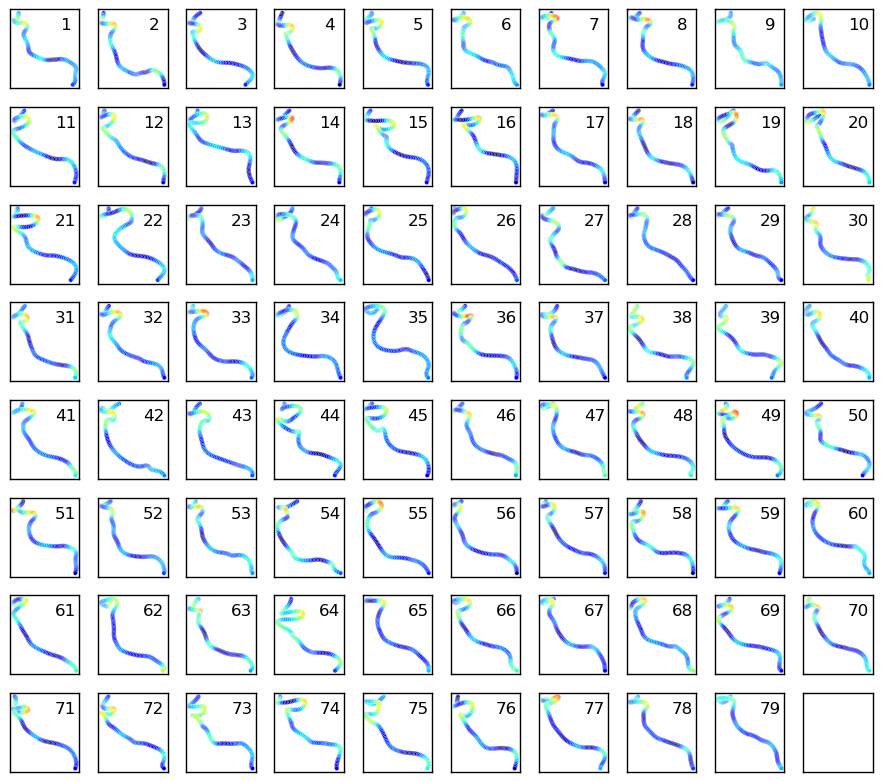

In [ ]:
import matplotlib.colors as mcolors

# 创建一个固定范围的归一化对象
norm = mcolors.Normalize(vmin=0, vmax=0.6)

def rotate_curves(curves, angle, axis):
    """
    旋转3D曲线数据集。
    
    :param curves: numpy数组，形状为(n, k, 3)，n是曲线数，k是每条曲线的点数。
    :param angle: 旋转角度，以度为单位。
    :param axis: 旋转轴，'x'、'y'或'z'。
    :return: 旋转后的曲线数据集。
    """
    # 将角度从度转换为弧度
    theta = np.radians(angle)
    
    # 根据轴选择旋转矩阵
    if axis == 'x':
        R = np.array([[1, 0, 0],
                      [0, np.cos(theta), -np.sin(theta)],
                      [0, np.sin(theta), np.cos(theta)]])
    elif axis == 'y':
        R = np.array([[np.cos(theta), 0, np.sin(theta)],
                      [0, 1, 0],
                      [-np.sin(theta), 0, np.cos(theta)]])
    elif axis == 'z':
        R = np.array([[np.cos(theta), -np.sin(theta), 0],
                      [np.sin(theta), np.cos(theta), 0],
                      [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    
    # 应用旋转矩阵到每个点
    rotated_curves = np.dot(curves, R.T)
    
    return rotated_curves

ro = rotate_curves(curve_bs, 45, 'x')  # 绕Z轴旋转45度
ro = rotate_curves(ro, 5, 'z')  # 绕Z轴旋转45度
ro = rotate_curves(ro, -15, 'y')  # 绕Z轴旋转45度


row = 8
col = 10
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 8),dpi=100)


shift_c= []
shift_t= []
# 遍历每个子图，并在其中绘制一些数据
for i in range(row):
    for j in range(col):
        ax = axes[i, j]  # 获取单个子图对象
        ax.set_xticks([])
        ax.set_yticks([])
        if i*col+j < 79:
            sns.scatterplot(x=ro[i*col+j,:,0], y=ro[i*col+j,:,1], ax=ax, alpha=1,s=10, c=curvatures[i*col+j][:119], cmap='jet',norm=norm)
            # ax.set_title(f'{i*col + j + 1}', fontsize=8)  # 设置子图的标题
            ax.text(0.8, 0.8, f'{i*col + j + 1}', fontsize=12, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.5, f't:{elastic_t}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.3, f'c:{elastic_c}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.set_facecolor(facecolor)

# 调整子图之间的间距
plt.tight_layout()

# 显示整个大图
plt.show()


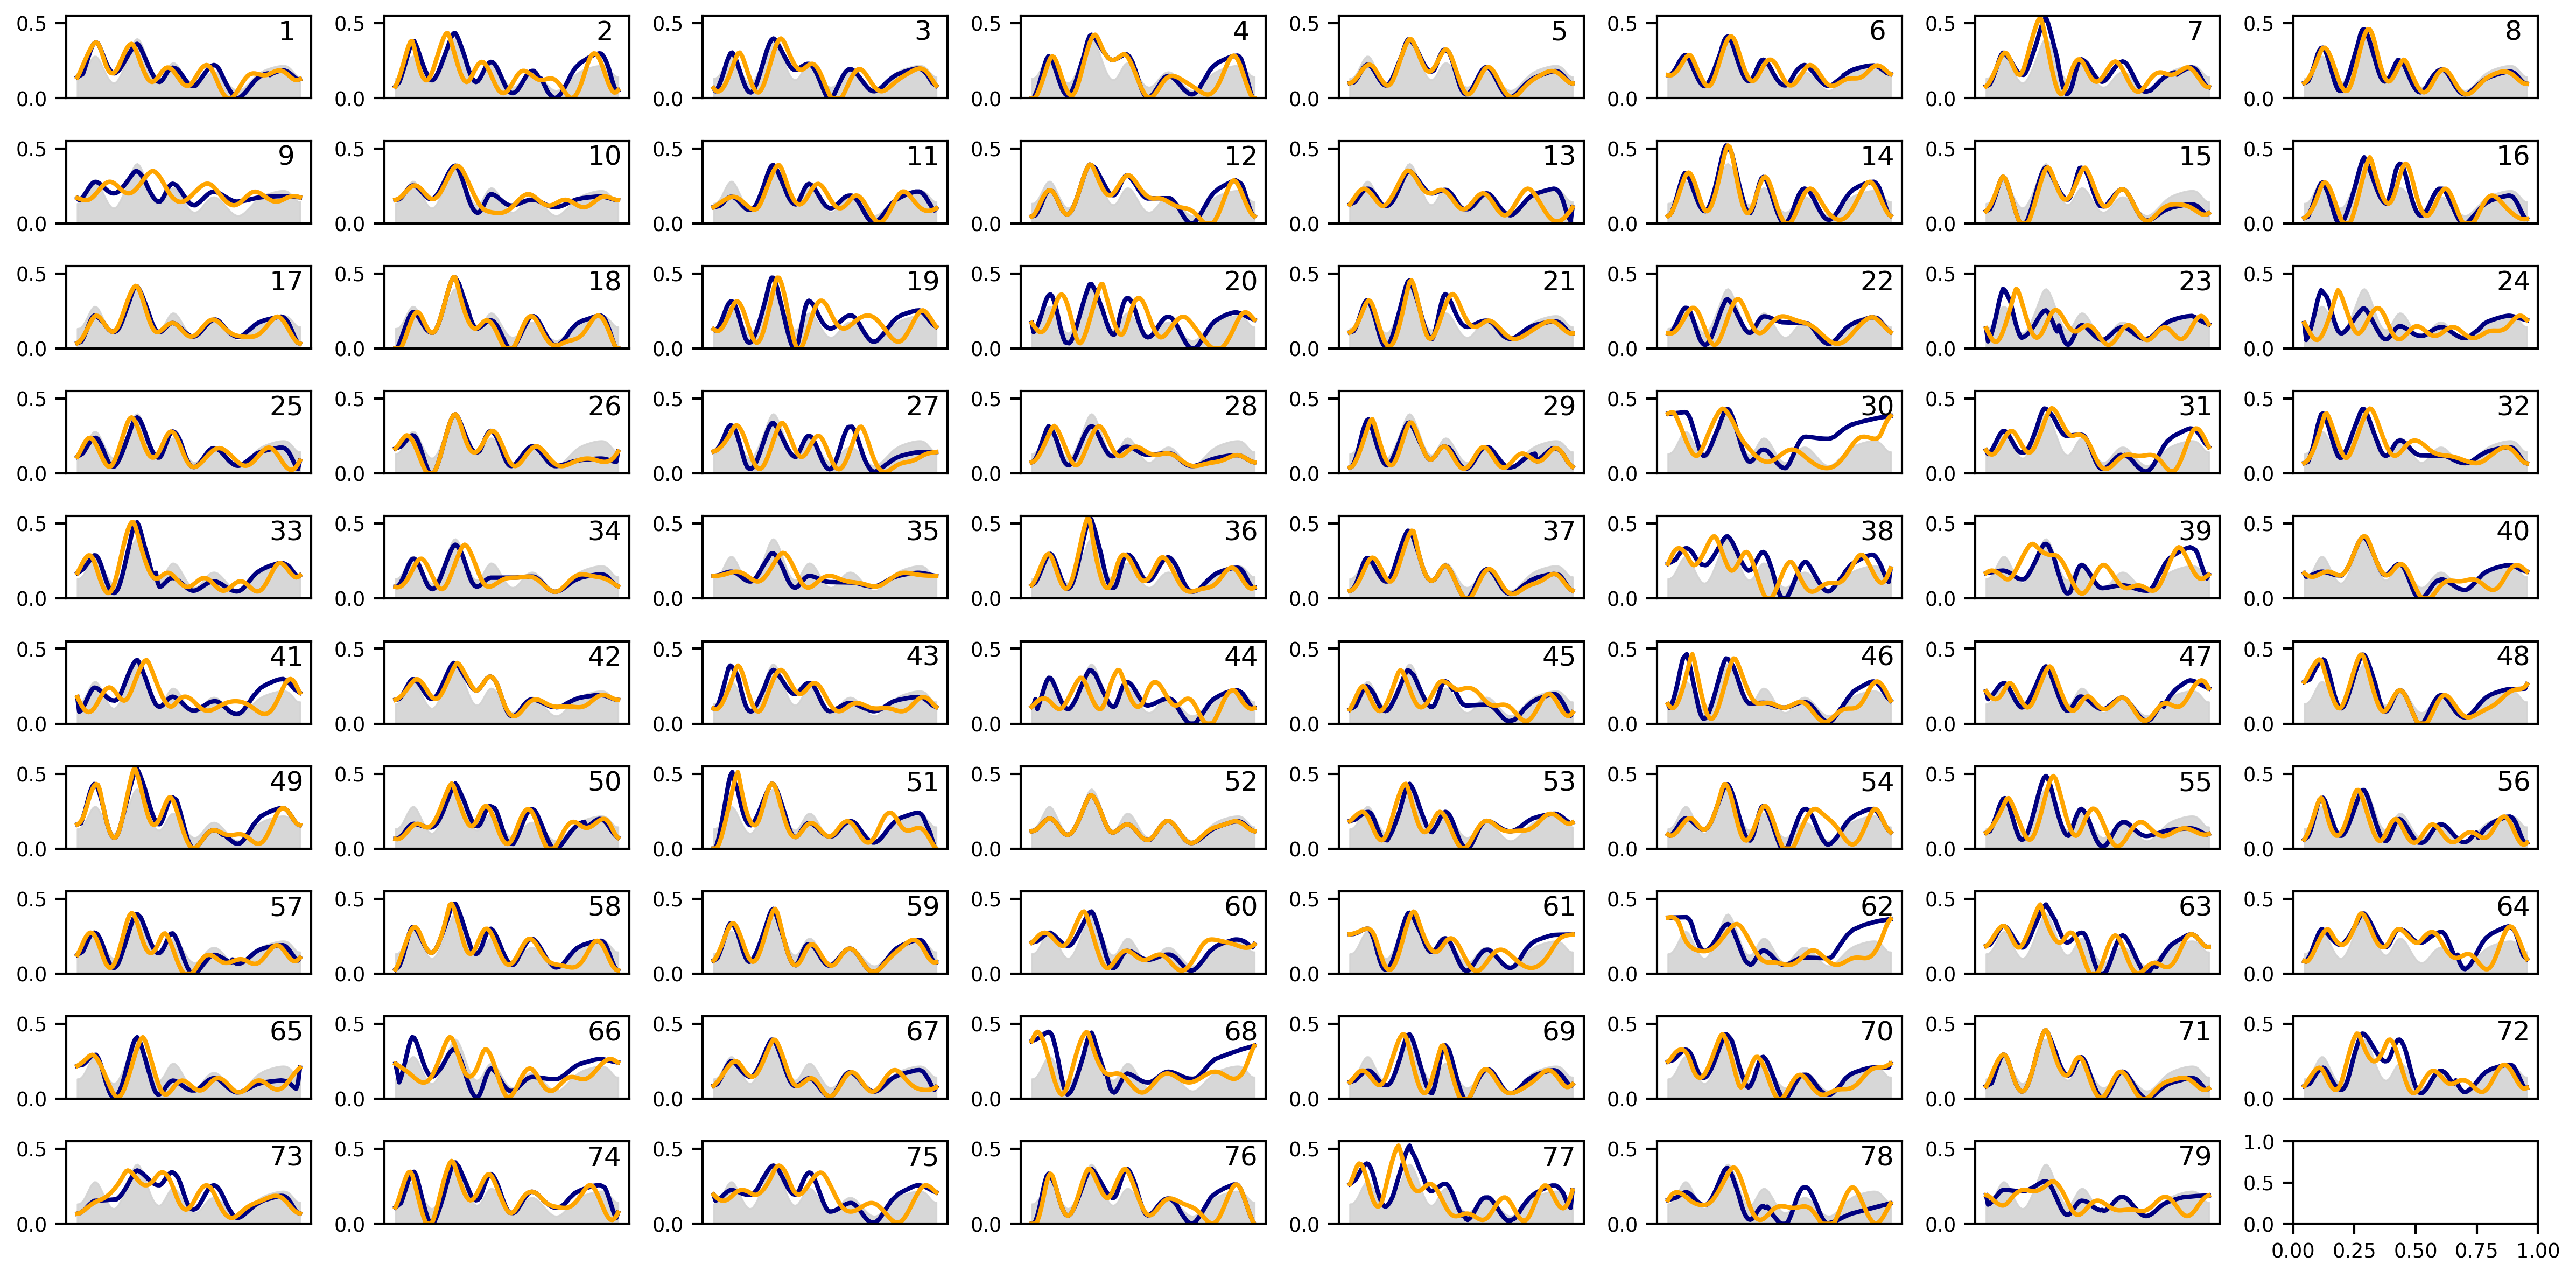

In [ ]:
# import matplotlib.pyplot as plt
sns.set_context("paper", font_scale=1)
# 创建8x10网格的图形，指定图的尺寸
fig, axes = plt.subplots(10, 8, figsize=(16, 8), dpi=300)

# 遍历所有曲线并在对应的子图中绘制
for udx in range(len(curvatures)):
    # 计算当前子图的行和列索引
    row = udx // 8
    col = udx % 8
    if udx < 79:
        ax = axes[row, col]
        # ax.plot(mean_function, alpha=1, linewidth=1, color="dimgray", label='Mean Curve')
        ax.fill_between(np.arange(0, len(mean_function)), mean_function, color='lightgray', alpha=0.9)
        ax.plot(aligned_curvatures[udx], alpha=1, color='navy', label='Aligned Curve',linewidth=2,)
        ax.plot(reparam_curvatures[udx], alpha=1, color='orange', label='Original Curve',linewidth=2,)
        ax.text(0.9, 0.8, f'{udx+1}', fontsize=12, ha='center', va='center', transform=ax.transAxes)
        # ax.text(0.75, 0.75, files_label[udx], fontsize=8, ha='center', va='center', transform=ax.transAxes)
        ax.set_ylim(0, 0.55)
        # ax.set_title(files[udx])
        ax.set_xticks([])
        
        # 可以根据需要启用此行，以设置自定义的 x 轴刻度
        # set_x_ticks_normalized(ax, curvatures[0])

        # 隐藏每个子图的图例，以避免图例过多
        # ax.legend()  # 如果需要单独显示图例，可以启用此行

# 调整布局，使子图间距适当
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

def find_corresponding_indices(aligned_curvatures, reparam_curvatures, warping_functions, mean_function):
    """
    找到每个 aligned_curvatures[j][peaks[i]] 和 aligned_curvatures[j][troughs[i]]
    在 reparam_curvatures[j] 上的对应索引。
    
    参数:
        aligned_curvatures (numpy.ndarray): 对齐后的曲线数组，形状为 (num_curves, num_points)。
        reparam_curvatures (numpy.ndarray): 原始曲线数组，形状为 (num_curves, num_points)。
        warping_functions (numpy.ndarray): 变形函数数组，形状为 (num_curves, num_points)。
        mean_function (numpy.ndarray): 对齐曲线的均值曲线，用于找到峰值和谷值。
    
    返回:
        dict: 每条曲线的峰值和谷值对应的索引，格式为:
              {j: {'peaks': [list of indices], 'troughs': [list of indices]}}
    """
    # 找到均值曲线的峰值和谷值
    peak_indices, _ = find_peaks(mean_function)
    trough_indices, _ = find_peaks(-mean_function)
    
    # 用于存储结果的字典
    corresponding_indices = {}

    # 遍历每条对齐曲线
    for j in range(len(aligned_curvatures)):
        # 获取当前曲线的变形函数
        warping_func = warping_functions[j]
        x_grid = np.linspace(0, 1, len(warping_func))
        
        # 创建反向插值函数，将 warping_func 映射回 x_grid
        inverse_warp = interp1d(warping_func, x_grid, bounds_error=False, fill_value="extrapolate")
        
        # 找到每个峰值在原始曲线上的对应索引
        peak_indices_reparam = []
        for peak_idx in peak_indices:
            original_x = inverse_warp(x_grid[peak_idx])
            closest_index = (np.abs(x_grid - original_x)).argmin()
            peak_indices_reparam.append(closest_index)
        
        # 找到每个谷值在原始曲线上的对应索引
        trough_indices_reparam = []
        for trough_idx in trough_indices:
            original_x = inverse_warp(x_grid[trough_idx])
            closest_index = (np.abs(x_grid - original_x)).argmin()
            trough_indices_reparam.append(closest_index)
        
        # 存储当前曲线的结果
        corresponding_indices[j] = {
            'peaks': peak_indices_reparam,
            'troughs': trough_indices_reparam
        }
    
    return corresponding_indices


# 调用函数并输出结果
corresponding_indices = find_corresponding_indices(aligned_curvatures, reparam_curvatures, warping_functions, mean_function)
print(corresponding_indices)

# 提取所有曲线的峰值对应索引
peak_indices_reparam = []
trough_indices_reparam = []
for j, indices in corresponding_indices.items():
    peak_indices_reparam.append(indices['peaks'])
    trough_indices_reparam.append(indices['troughs'])

peak_indices_reparam = np.array(peak_indices_reparam)
trough_indices_reparam = np.array(trough_indices_reparam)

indices_reparam = np.concatenate((peak_indices_reparam, trough_indices_reparam), axis=1)
print(indices_reparam.shape)

peaks_troughs = np.array(np.concatenate((peak_indices,trough_indices)), dtype=int)
peak_trough_values = []
for i in range(len(files)):
    # print (aligned_curvatures[i][peaks].shape)
    peak_trough_values.append(aligned_curvatures[i][peaks_troughs])
peak_trough_values = np.array(peak_trough_values)
print (peak_trough_values.shape)


{0: {'peaks': [9, 35, 54, 77, 112], 'troughs': [20, 47, 66, 91]}, 1: {'peaks': [10, 37, 56, 76, 113], 'troughs': [22, 49, 68, 79]}, 2: {'peaks': [5, 28, 49, 68, 109], 'troughs': [15, 41, 61, 82]}, 3: {'peaks': [7, 30, 52, 71, 112], 'troughs': [17, 44, 62, 80]}, 4: {'peaks': [8, 31, 50, 72, 112], 'troughs': [18, 45, 62, 85]}, 5: {'peaks': [7, 30, 48, 69, 105], 'troughs': [17, 42, 60, 84]}, 6: {'peaks': [8, 35, 52, 77, 112], 'troughs': [21, 47, 66, 92]}, 7: {'peaks': [8, 30, 48, 72, 112], 'troughs': [16, 42, 61, 85]}, 8: {'peaks': [3, 24, 41, 54, 92], 'troughs': [11, 35, 48, 64]}, 9: {'peaks': [8, 31, 43, 53, 104], 'troughs': [18, 40, 47, 67]}, 10: {'peaks': [8, 29, 47, 68, 116], 'troughs': [16, 42, 58, 83]}, 11: {'peaks': [9, 32, 50, 76, 112], 'troughs': [19, 45, 61, 80]}, 12: {'peaks': [11, 32, 53, 75, 118], 'troughs': [21, 45, 65, 89]}, 13: {'peaks': [8, 31, 50, 70, 112], 'troughs': [18, 45, 62, 82]}, 14: {'peaks': [9, 31, 49, 73, 114], 'troughs': [19, 45, 61, 85]}, 15: {'peaks': [8, 

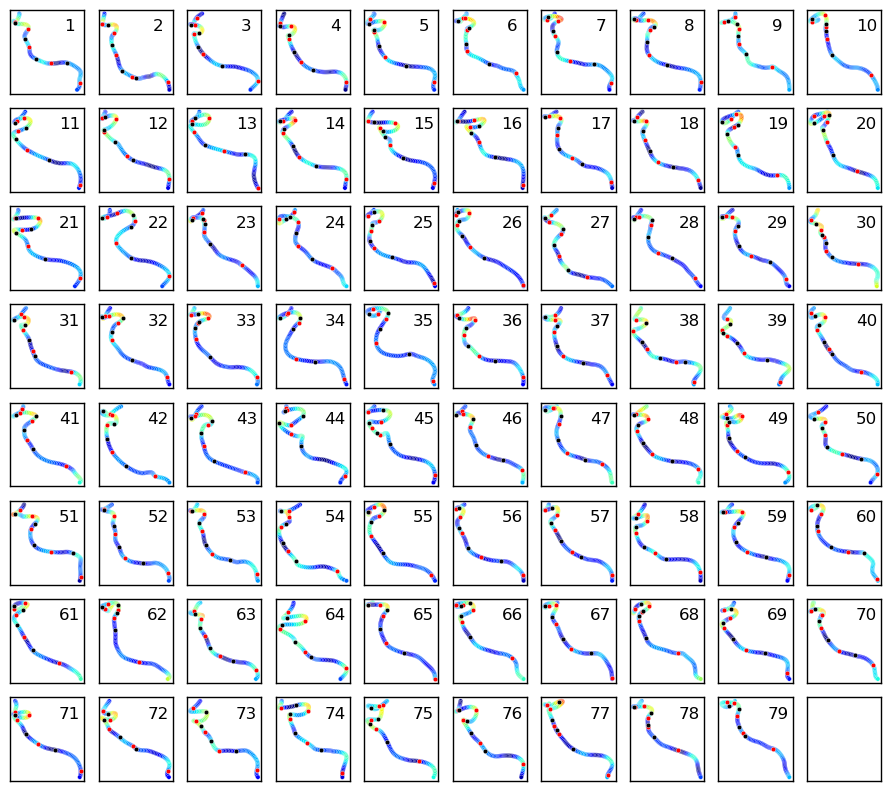

In [ ]:
row = 8
col = 10
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 8),dpi=100)


shift_c= []
shift_t= []
# 遍历每个子图，并在其中绘制一些数据
for i in range(row):
    for j in range(col):
        ax = axes[i, j]  # 获取单个子图对象
        ax.set_xticks([])
        ax.set_yticks([])
        if i*col+j < 79:
            sns.scatterplot(x=ro[i*col+j,:,0], y=ro[i*col+j,:,1], ax=ax, alpha=1,s=10, c=curvatures[i*col+j][:119], cmap='jet',norm=norm)
            sns.scatterplot(x=ro[i*col+j,peak_indices_reparam[i*col+j],0], y=ro[i*col+j,peak_indices_reparam[i*col+j],1], ax=ax, alpha=1,s=10, c='red')
            sns.scatterplot(x=ro[i*col+j,trough_indices_reparam[i*col+j],0], y=ro[i*col+j,trough_indices_reparam[i*col+j],1], ax=ax, alpha=1,s=10, c='k')
            
            
            # ax.set_title(f'{i*col + j + 1}', fontsize=8)  # 设置子图的标题
            ax.text(0.8, 0.8, f'{i*col + j + 1}', fontsize=12, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.5, f't:{elastic_t}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.3, f'c:{elastic_c}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.set_facecolor(facecolor)

# 调整子图之间的间距
plt.tight_layout()

# 显示整个大图
plt.show()


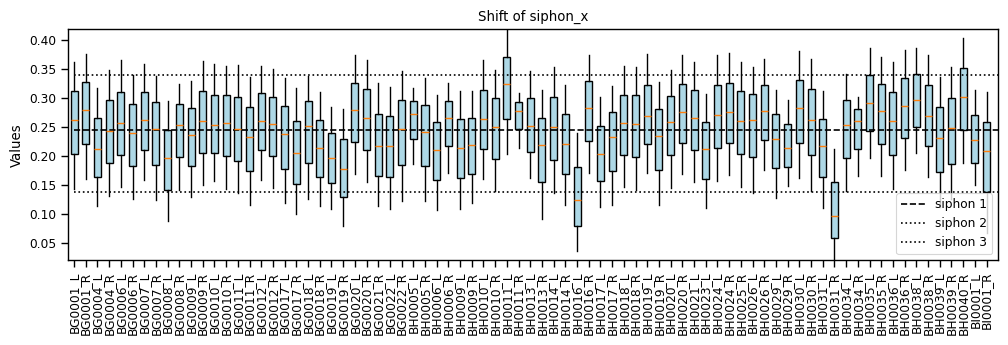

In [ ]:
# siphon分布在哪里？

siphon_x_pre = np.stack((indices_reparam[:,5], indices_reparam[:,1], indices_reparam[:,6]), axis=1)

siphon_x = []

for i in range(len(files)):
    center = calculate_curve_length(original_centerlines[i][:siphon_x_pre[i][1]])/calculate_curve_length(original_centerlines[i])
    proximal = calculate_curve_length(original_centerlines[i][:siphon_x_pre[i][-1]])/calculate_curve_length(original_centerlines[i])
    distal = calculate_curve_length(original_centerlines[i][:siphon_x_pre[i][0]])/calculate_curve_length(original_centerlines[i])

    # center_aligned = calculate_curve_length(alig)

    # print (center, proximal, distal)

    siphon_x.append([distal, center, proximal])
siphon_x = np.array(siphon_x)
# print (siphon_x)

# mean_function_siphon = np.array([mean_function[peak_troughs[0]], mean_function[peak_troughs[1]], mean_function[peak_troughs[2]]])



# 为 x 轴生成索引
x = np.arange(siphon_x.shape[0])

# 创建图形并绘制每列的折线图和填充区域
plt.figure(figsize=(12, 3))

# # 绘制三条带面积的折线图
# for i in range(siphon_x.shape[1]):
#     plt.plot(x, siphon_x[:, i], label=f'Line {i + 1}')
#     plt.fill_between(x, siphon_x[:, i], alpha=0.3)  # 填充折线下方区域

plt.boxplot(siphon_x.T, positions=range(len(curve_bs)), widths=0.6, patch_artist=True, showfliers=False, showcaps=False, boxprops=dict(facecolor='lightblue'))

plt.hlines(np.mean(siphon_x[:,1]), 0, siphon_x.shape[0], colors='k', linestyles='--', label='siphon 1')  # 添加零线
plt.hlines(np.mean(siphon_x[:,0]), 0, siphon_x.shape[0], colors='k', linestyles=':', label='siphon 2')  # 添加零线
plt.hlines(np.mean(siphon_x[:,2]), 0, siphon_x.shape[0], colors='k', linestyles=':', label='siphon 3')  # 添加零线



# 设置x轴标签
plt.xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串


# 添加标签和标题
# plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Shift of siphon_x")
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

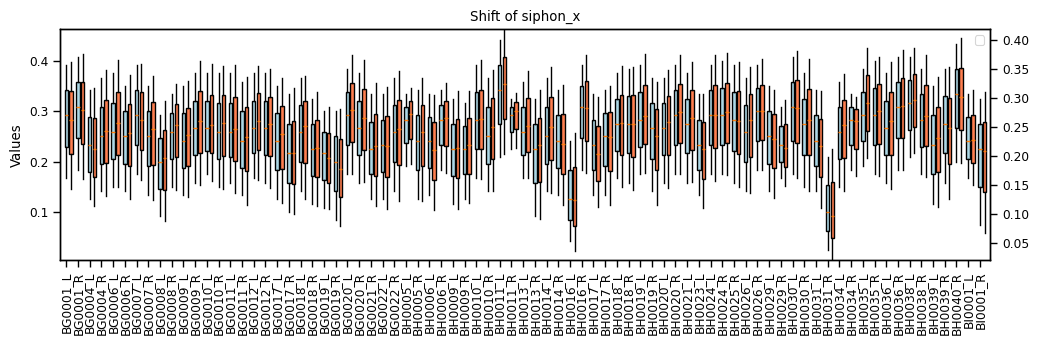

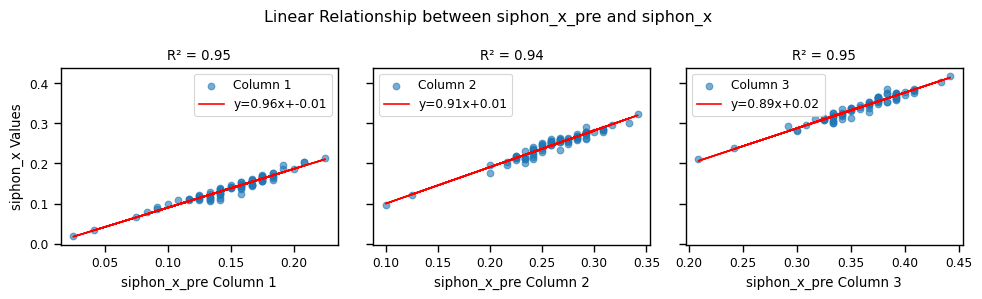

In [ ]:
# 用弧长计算siphon位置，和用索引计算siphon位置，有多大差异？
# siphon_x_pre = np.stack((indices_reparam[:,5], indices_reparam[:,1], indices_reparam[:,6]), axis=1)


from scipy.stats import linregress
# 为 x 轴生成索引
x = np.arange(siphon_x_pre.shape[0])

# 创建图形并绘制每列的折线图和填充区域
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(111)
# # 绘制三条带面积的折线图
# for i in range(siphon_x.shape[1]):
#     plt.plot(x, siphon_x[:, i], label=f'Line {i + 1}')
#     plt.fill_between(x, siphon_x[:, i], alpha=0.3)  # 填充折线下方区域

ax.boxplot((siphon_x_pre/len(curvatures[0])).T, positions=np.arange(len(curve_bs)), widths=0.3, patch_artist=True, showfliers=False, showcaps=False, boxprops=dict(facecolor='lightblue'))
ax2 = ax.twinx()
ax2.boxplot(siphon_x.T, positions=np.arange(len(curve_bs))+0.4, widths=0.3, patch_artist=True, showfliers=False, showcaps=False, boxprops=dict(facecolor='coral'))



# 设置x轴标签
ax.set_xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串


# 添加标签和标题
# plt.xlabel("Index")
ax.set_ylabel("Values")
plt.title("Shift of siphon_x")
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

# 初始化图形
fig, axs = plt.subplots(1, siphon_x.shape[1], figsize=(10, 3), sharey=True)
fig.suptitle("Linear Relationship between siphon_x_pre and siphon_x")

for i in range(siphon_x.shape[1]):
    # 获取 siphon_x_pre 和 siphon_x 的对应列
    X = siphon_x_pre[:, i] / len(curvatures[0])  # 归一化处理
    Y = siphon_x[:, i]
    
    # 绘制散点图
    axs[i].scatter(X, Y, label=f'Column {i + 1}', alpha=0.6)
    
    # 线性回归拟合
    slope, intercept, r_value, p_value, std_err = linregress(X, Y)
    axs[i].plot(X, slope * X + intercept, color="red", label=f'y={slope:.2f}x+{intercept:.2f}')
    
    # 显示相关信息
    axs[i].set_xlabel(f'siphon_x_pre Column {i + 1}')
    axs[i].set_title(f'R² = {r_value**2:.2f}')
    axs[i].legend()

axs[0].set_ylabel("siphon_x Values")
plt.tight_layout()
plt.show()

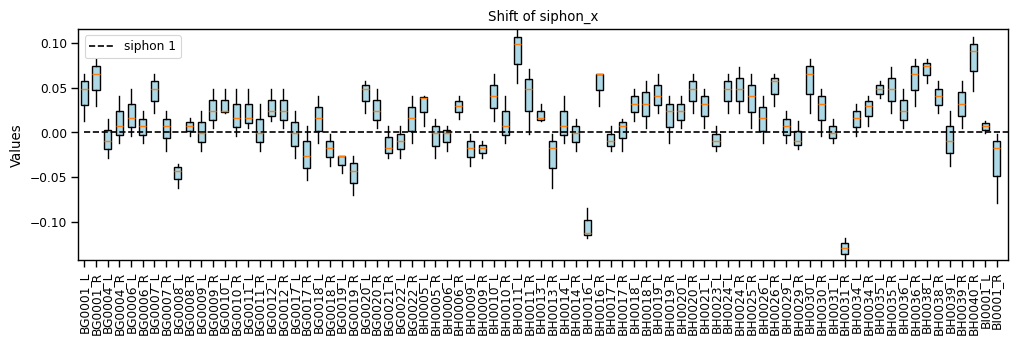

(3, 79)


In [ ]:
# 创建图形并绘制每列的折线图和填充区域
plt.figure(figsize=(12, 3))


siphon_on_mean_function = ([peaks_troughs[5], peaks_troughs[1], peaks_troughs[6]])*np.array([0.97,0.91,0.89])
# print (siphon_on_mean_function)
# print (siphon_x_pre)
plt.boxplot(((siphon_x_pre-siphon_on_mean_function).T)/len(mean_function), positions=range(len(curve_bs)), widths=0.6, patch_artist=True, showfliers=False, showcaps=False, boxprops=dict(facecolor='lightblue'))

plt.hlines(0, 0, siphon_x.shape[0], colors='k', linestyles='--', label='siphon 1')  # 添加零线

# 设置x轴标签
plt.xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串


# 添加标签和标题
# plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Shift of siphon_x")
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

print ((((siphon_x_pre-siphon_on_mean_function).T)/len(mean_function)).shape)


(3, 79)


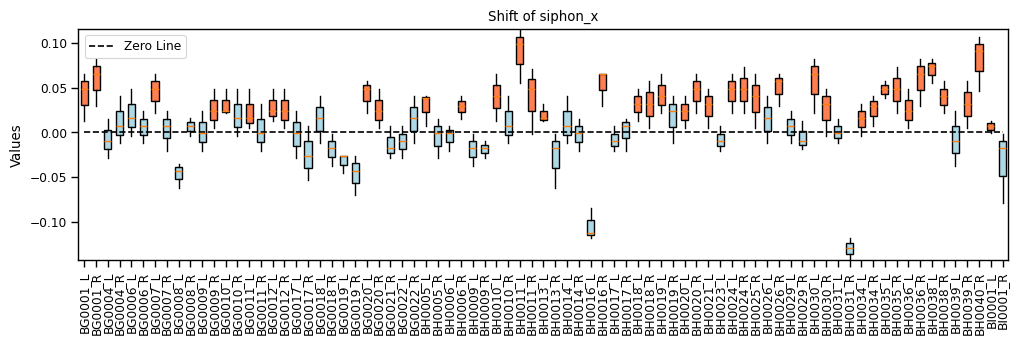

(79,)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 创建图形
plt.figure(figsize=(12, 3))

# 计算并调整数据
adjusted_data = ((siphon_x_pre - siphon_on_mean_function) / len(mean_function)).T


print (adjusted_data.shape)

Shift = []
# 绘制每列的 boxplot，根据均值设置不同颜色
for i in range(adjusted_data.shape[1]):
    column_data = adjusted_data[:, i]
    mean_value = np.mean(column_data)-np.std(column_data)
    color = 'coral' if mean_value > 0 else 'lightblue'
    
    # 绘制 boxplot
    plt.boxplot(column_data, positions=[i], widths=0.6, patch_artist=True, 
                showfliers=False, showcaps=False, boxprops=dict(facecolor=color))
    Shift.append(mean_value)

# 添加零线
plt.hlines(0, 0, adjusted_data.shape[1] - 1, colors='k', linestyles='--', label='Zero Line')

# 设置x轴标签
plt.xticks(ticks=range(len(files)), labels=files_label, rotation=90)

# 添加标签和标题
plt.ylabel("Values")
plt.title("Shift of siphon_x")
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()
Shift = np.array(Shift)

print (Shift.shape)

(5,)


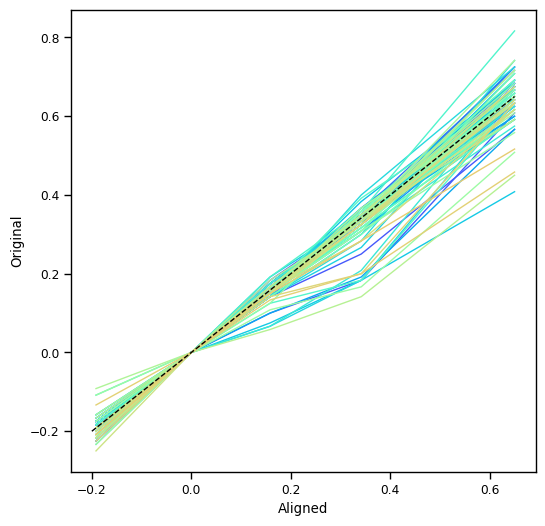

In [ ]:
# 其他landmark相对于siphon的移动情况

# mean_function_diff = peaks_troughs - peaks_troughs[1] # 对齐后的各点与siphon的差值
mean_function_diff = peak_indices - peak_indices[1] # 对齐后的各点与siphon的差值
curvature_diffs = []
for i in range(len(files)):
    # curvature_diffs.append(indices_reparam[i] - indices_reparam[i][1]) # 对齐前的各点与siphon的差值
    curvature_diffs.append(peak_indices_reparam[i]-peak_indices_reparam[i][1]) # 对齐前的各点与siphon的差值
curvature_diffs = np.array(curvature_diffs)
# print (mean_function_diff)
# print (curvature_diffs)
# diff_indices = ((curvature_diffs-mean_function_diff)/len(mean_function)) # 如果为负，意味着需要收缩才能对齐，则原先的曲线是舒张的
diff_indices = ((curvature_diffs)/len(mean_function)) 
print (diff_indices[0].shape)
mean_diff_indices = (mean_function_diff/len(mean_function))


# # print (diff_indices)
colors = cm.rainbow(np.linspace(0.05, 0.70, num_curves))
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)


for i in range(79):
    ax.plot(mean_diff_indices, diff_indices[i], alpha=1, linewidth=1, color=colors[i])
# for j in [0,2,3,4]:
#     for i in range(len(diff_indices)):
#         ax.scatter(i, diff_indices[i][j]/Shift[i], marker='${}$'.format(j+1), color=colors[i])

# ax.hlines(0, 0, siphon_x.shape[0], colors='k', linestyles='--', label='siphon 1')  # 添加零线
# plt.hlines(-1, 0, siphon_x.shape[0], colors='k', linestyles=':', label='siphon 0')  # 添加零线
# plt.hlines(1, 0, siphon_x.shape[0], colors='k', linestyles=':', label='siphon 2')  # 添加零线
# ax.set_xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串
ax.set_ylabel("Original")
ax.set_xlabel("Aligned")
# ax.set_title("Area Plots for Each Column of siphon_x")
# ax.set_ylim([-5,5])

ax.plot([-0.2,0.65],[-0.2,0.65], color='k', linestyle='--', linewidth=1)
# ax.autoscale(enable=True, axis='x', tight=True)
# ax.autoscale(enable=True, axis='y', tight=True)


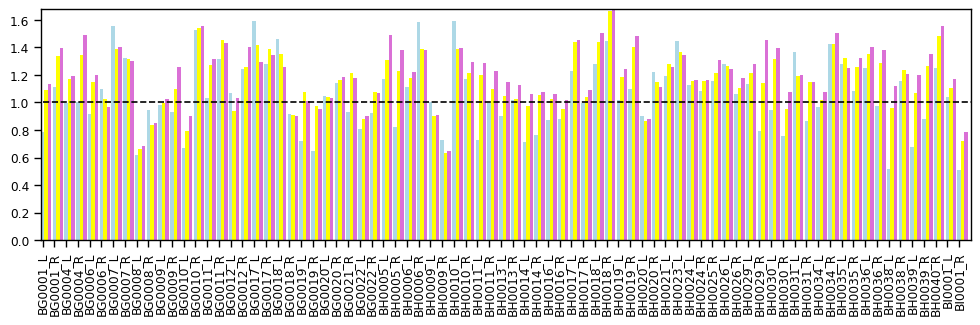

In [ ]:
# siphon相对mean function中的siphon的intensity变化情况，对比landmark和mean function中的landmark的intensity变化情况，对比整体的intensity变化情况

siphon_curvature = (aligned_curvatures[:, peak_indices[1]] - (aligned_curvatures[:, trough_indices[0]]+aligned_curvatures[:, trough_indices[1]])/2)/(mean_function[peak_indices[1]]-(mean_function[trough_indices[0]]+mean_function[trough_indices[1]])/2)
plt.figure(figsize=(12, 3))


landmark_std = np.std(aligned_curvatures[:,peaks_troughs],axis=1)
mean_landmark_std = np.std(mean_function[peaks_troughs])
landmark_average = landmark_std/mean_landmark_std

total_std = np.std(aligned_curvatures,axis=1)
mean_total_std = np.std(mean_function)
total_average = total_std/mean_total_std


# 第一个柱状图
plt.bar(np.arange(len(siphon_curvature)), siphon_curvature, width=0.3, color='lightblue', label="Siphon Curvature")

# 第二个柱状图，x 位置偏移 0.4
plt.bar(np.arange(len(landmark_average)) + 0.3, landmark_average, width=0.3, color='yellow', label="Landmark Average")
plt.bar(np.arange(len(total_average)) + 0.6, total_average, width=0.3, color='orchid', label="Total Average")

plt.hlines(1, 0, len(siphon_curvature), colors='k', linestyles='--', label='Zero')  
# 设置x轴标签
plt.xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

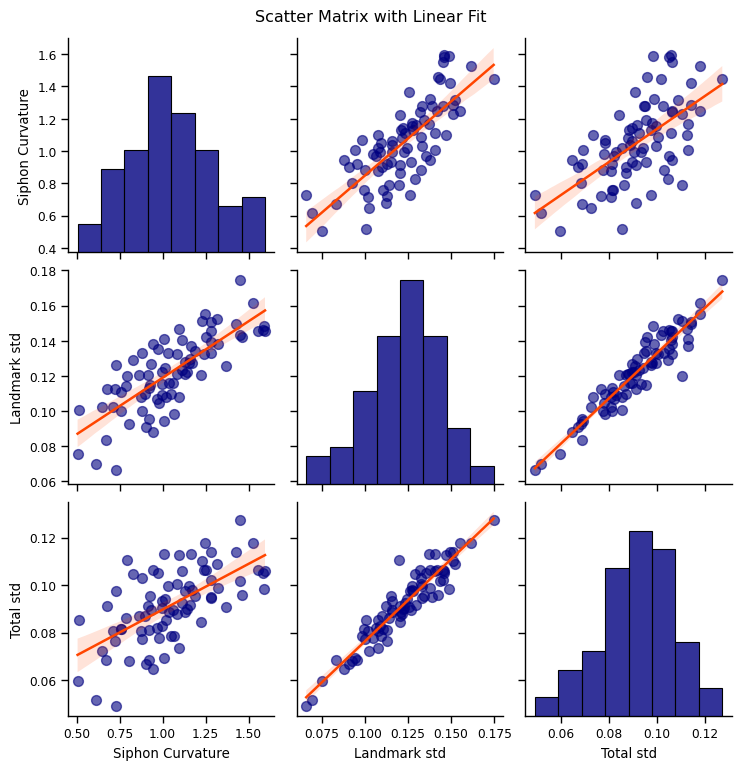

In [ ]:
import pandas as pd

# 创建数据框，将数据转为 Pandas 格式便于 Seaborn 处理
data = pd.DataFrame({
    'Siphon Curvature': siphon_curvature,
    'Landmark std': landmark_std,
    'Total std': total_std
})

# print (data)
# 使用 seaborn 绘制带有拟合曲线的散点图矩阵
sns.pairplot(
    data,
    kind='reg',
    plot_kws={
        'line_kws': {'color': 'orangered'},  # 设置回归线颜色为 navy
        'scatter_kws': {'color': 'navy', 'alpha': 0.6, 's': 50}  # 设置散点颜色为 navy
    },
    diag_kws={
        'color': 'navy',  # 设置直方图的柱子颜色为 navy
        'alpha': 0.8  # 可选，调整透明度
    }
)
# 添加标题
plt.suptitle("Scatter Matrix with Linear Fit", y=1.02)
plt.show()

# 结果说明这些landmark上的intensity很有代表性（？）

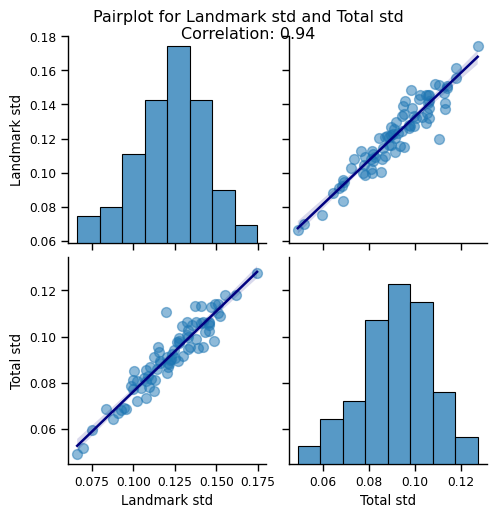

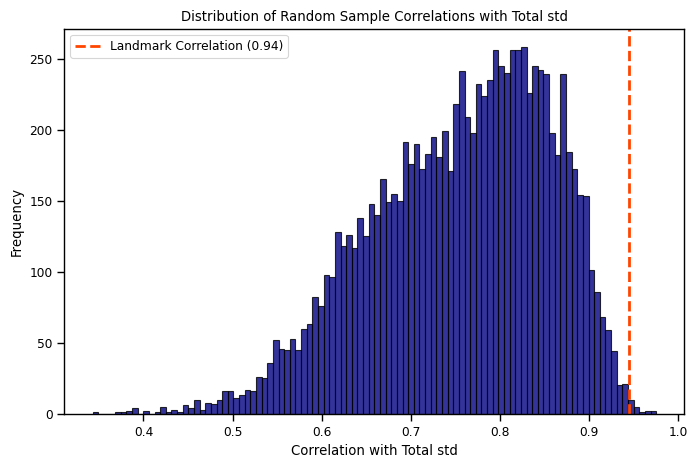

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 计算 landmark_std 和 total_std
landmark_std = np.std(aligned_curvatures[:, peaks_troughs], axis=1)
total_std = np.std(aligned_curvatures, axis=1)

# 创建 DataFrame 保存 Siphon Curvature, Landmark std, Total std
data = pd.DataFrame({
    'Siphon Curvature': siphon_curvature,
    'Landmark std': landmark_std,
    'Total std': total_std
})

# 计算 landmark_std 和 total_std 之间的相关系数
landmark_total_corr = np.corrcoef(landmark_std, total_std)[0, 1]

# 随机选择10个点多次，并计算它们的标准差和 total_std 的相关性
random_corrs = []
num_random_samples = 10000  # 设置随机采样次数
num_random_points = 9    # 每次选择10个随机点

for _ in range(num_random_samples):
    random_points = np.random.choice(aligned_curvatures.shape[1], num_random_points, replace=False)
    random_std = np.std(aligned_curvatures[:, random_points], axis=1)
    random_corr = np.corrcoef(random_std, total_std)[0, 1]
    random_corrs.append(random_corr)

# 转换为 DataFrame 以便于绘制和比较
random_corrs_df = pd.DataFrame({
    'Random Sample Correlation': random_corrs
})

# 绘制 landmark_std 和 total_std 的配对图，并显示相关系数
sns.pairplot(data[['Landmark std', 'Total std']], kind='reg', plot_kws={'line_kws': {'color': 'navy'}, 'scatter_kws': {'alpha': 0.5, 's': 50}})
plt.suptitle(f"Pairplot for Landmark std and Total std\nCorrelation: {landmark_total_corr:.2f}", y=1.02)
plt.show()

# 绘制随机样本相关性直方图，添加 landmark_std 和 total_std 相关性的垂直线
plt.figure(figsize=(8, 5))
plt.hist(random_corrs, bins=100, alpha=0.8, color='navy', edgecolor='k')
plt.axvline(x=landmark_total_corr, color='orangered', linestyle='--', linewidth=2, label=f'Landmark Correlation ({landmark_total_corr:.2f})')
plt.xlabel("Correlation with Total std")
plt.ylabel("Frequency")
plt.title("Distribution of Random Sample Correlations with Total std")
plt.legend()
plt.show()


(5, 79)


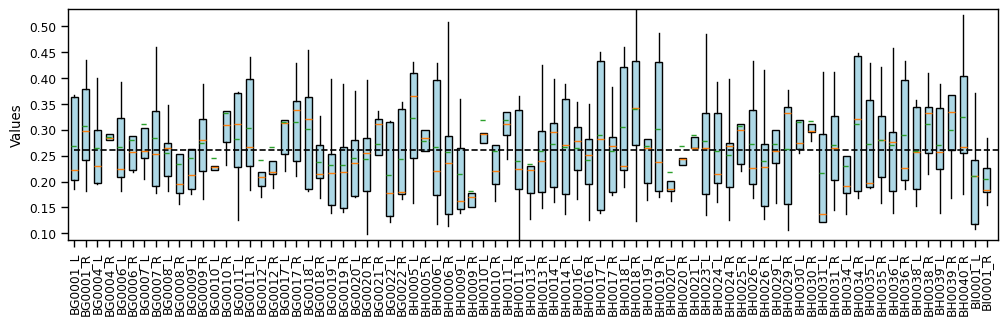

In [ ]:
plt.figure(figsize=(12, 3))

# # 绘制三条带面积的折线图
# for i in range(siphon_x.shape[1]):
#     plt.plot(x, siphon_x[:, i], label=f'Line {i + 1}')
#     plt.fill_between(x, siphon_x[:, i], alpha=0.3)  # 填充折线下方区域
# print (peaks_troughs)
# a = aligned_curvatures[:,peaks_troughs].T
a = aligned_curvatures[:,peak_indices].T
print (a.shape)
plt.boxplot(a, positions=range(len(curve_bs)), widths=0.6, patch_artist=True, showfliers=False, showcaps=False, boxprops=dict(facecolor='lightblue'),showmeans=True, meanline=True)

# plt.hlines(np.mean(mean_function[peaks_troughs]), 0, siphon_x.shape[0], colors='k', linestyles='--', label='siphon 1')  # 添加零线
plt.hlines(np.mean(mean_function[peak_indices]), 0, siphon_x.shape[0], colors='k', linestyles='--', label='siphon 1')  # 添加零线
# plt.hlines(trough_indices[0], 0, siphon_x.shape[0], colors='k', linestyles=':', label='siphon 0')  # 添加零线
# plt.hlines(trough_indices[1], 0, siphon_x.shape[0], colors='k', linestyles=':', label='siphon 2')  # 添加零线


# 添加标签和标题
# 设置x轴标签
plt.xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串
plt.ylabel("Values")
# plt.title("Area Plots for Each Column of siphon_x")
# plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

Mean Error: 0.00381
Standard Deviation: 0.00341
Max Error: 0.01633
Min Error: 0.00038


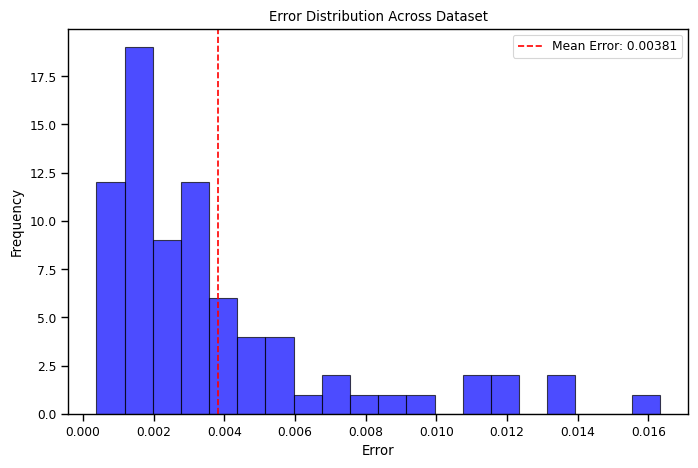

In [ ]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt


def find_peaks_and_troughs(reparam_curvature):
    """
    找到所有的峰值和谷值的索引，并按大小排序。
    
    参数:
        reparam_curvature (numpy.ndarray): 一维数组，表示曲线数据。
    
    返回:
        dict: 包含所有峰值和谷值索引的字典，格式为 {'peaks': list, 'troughs': list}。
    """
    peaks, _ = find_peaks(reparam_curvature)  # 找到峰值
    troughs, _ = find_peaks(-reparam_curvature)  # 找到谷值
    
    peaks.sort()
    troughs.sort()
    
    return {'peaks': peaks, 'troughs': troughs}


def fit_and_evaluate_bspline(reparam_curvature, peak_trough_indices):
    """
    使用 B样条拟合，并评估拟合误差。
    
    参数:
        reparam_curvature (numpy.ndarray): 一维数组，表示曲线数据。
        peak_trough_indices (dict): 包含峰值和谷值索引的字典，格式为 {'peaks': list, 'troughs': list}。
    
    返回:
        float: 拟合曲线与原曲线的误差。
    """
    # 合并峰值和谷值索引并排序
    indices = np.sort(np.concatenate([peak_trough_indices['peaks'], peak_trough_indices['troughs']]))
    values = reparam_curvature[indices]  # 获取对应的值

    # 构建 B样条拟合
    bspline = make_interp_spline(indices, values, k=3)  # k=3 表示三次样条
    x_fine = np.linspace(indices[0], indices[-1], 500)  # 生成细化点
    y_fine = bspline(x_fine)  # 计算拟合值

    # 原曲线在细化点上的值
    original_values = np.interp(x_fine, np.arange(len(reparam_curvature)), reparam_curvature)

    # 计算误差
    error = np.mean((y_fine - original_values) ** 2)

    # # 绘图
    # plt.plot(x_fine, y_fine, label="BSpline Fit", color='blue')  # 绘制拟合曲线
    # plt.plot(x_fine, original_values, label="Original Curve", color='orange')  # 绘制原曲线
    # plt.scatter(indices, values, color='red', label='Landmarks')  # 绘制数据点
    # plt.legend()
    # plt.title(f"Fitting Error: {error:.5f}")
    # plt.show()

    return error



# 假设 `files` 是数据集的标识列表，`reparam_curvatures` 是所有曲线的数组

# 用于存储所有曲线的误差
errors = []

# 对每个曲线进行处理
for i in range(len(files)):
    temp_reparam_c = reparam_curvatures[i]

    # 找到峰值和谷值
    peak_trough_indices = find_peaks_and_troughs(temp_reparam_c)

    # 拟合并评估误差
    error = fit_and_evaluate_bspline(temp_reparam_c, peak_trough_indices)
    errors.append(error)

# 转为 NumPy 数组以便统计
errors = np.array(errors)

# 计算统计量
mean_error = np.mean(errors)
std_error = np.std(errors)
max_error = np.max(errors)
min_error = np.min(errors)

# 输出统计结果
print(f"Mean Error: {mean_error:.5f}")
print(f"Standard Deviation: {std_error:.5f}")
print(f"Max Error: {max_error:.5f}")
print(f"Min Error: {min_error:.5f}")

# 绘制误差分布的直方图
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(mean_error, color='red', linestyle='--', label=f'Mean Error: {mean_error:.5f}')
plt.title("Error Distribution Across Dataset")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()
